In [1]:
import pandas as pd
import openai
import time
from concurrent.futures import ThreadPoolExecutor, as_completed
# 设置 DeepSeek API 地址和 Key（注意：建议将 API key 存在环境变量中，避免泄露）
openai.api_base = "https://api.deepseek.com"
openai.api_key = ""
# 初始化客户端（新版 SDK 必须使用 `OpenAI()` 实例）
client = openai.OpenAI(base_url=openai.api_base, api_key=openai.api_key)

df = pd.read_csv("bbc_ukraine_2020_2024_advanced_filtered.csv")

In [2]:
df["bias"] = "" 
df

,title,published_date,authors,description,section,content,link,top_image,match_count,keyword_score,bias
0,Greta Thunberg changes Twitter name to 'Sharon...,2020-01-03,['https://www.facebook.com/bbcnews'],It was a playful nod to actor Amanda Henderson...,Europe,Greta Thunberg has changed her name to Sharon ...,http://www.bbc.co.uk/news/world-europe-50989594,https://ichef.bbci.co.uk/news/976/cpsprodpb/13...,2,2.7,
1,CES 2020: The Russian car with no driver at th...,2020-01-07,['https://www.facebook.com/bbcnews'],The BBC is offered a ride in a driverless car ...,Technology,Russian firm Yandex is hoping to impress CES d...,http://www.bbc.co.uk/news/technology-51003224,https://ichef.bbci.co.uk/news/976/cpsprodpb/5F...,2,2.7,
2,Impeachment trial: How Trump lawyers set out t...,2020-01-25,['https://www.facebook.com/bbcnews'],"In two hours of arguments, the Trump team accu...",US & Canada,'Read the transcript' has become a feature at ...,http://www.bbc.co.uk/news/live/world-us-canada...,https://m.files.bbci.co.uk/modules/bbc-morph-n...,2,3.8,
3,Greta Thunberg changes Twitter name to 'Sharon...,2020-01-04,['https://www.facebook.com/bbcnews'],It was a playful nod to actor Amanda Henderson...,Europe,Greta Thunberg has changed her name to Sharon ...,http://www.bbc.co.uk/news/world-europe-50989594,https://ichef.bbci.co.uk/news/976/cpsprodpb/13...,2,2.7,
4,Aftermath of Ukrainian passenger plane crash i...,2020-01-08,[],Officials say there were more than 170 people ...,NaN,A Ukrainian Boeing-737 with more than 170 peop...,http://www.bbc.co.uk/news/world-middle-east-51...,https://ichef.bbci.co.uk/news/1024/branded_new...,2,3.5,
...,...,...,...,...,...,...,...,...,...,...,...
6309,"Shaken by Assad's sudden fall, Syria faces sei...",2024-12-09,https://www.facebook.com/bbcnews,The worst scenario for Syrians is that their c...,Middle East,"Syrians may be celebrating the fall of Assad, ...",http://www.bbc.co.uk/news/articles/cp8n20z080ko,https://ichef.bbci.co.uk/ace/standard/3840/cps...,2,3.5,
6310,Police investigating Labour's Edinburgh counci...,2024-12-09,https://www.facebook.com/bbcnews,Scottish Labour confirmed Cammy Day has been s...,"Edinburgh, Fife & East",Allegations about Cammy Day's behaviour are be...,http://www.bbc.co.uk/news/articles/c9wllwex1j8o,https://ichef.bbci.co.uk/ace/standard/2560/cps...,2,3.5,
6311,Fall of Assad is a blow to Russia's prestige -...,2024-12-09,https://www.facebook.com/bbcnews,Russian firepower helped keep the Syrian presi...,World,Steve Rosenberg: Fall of Assad is a blow to Ru...,http://www.bbc.co.uk/news/articles/clygege97qwo,https://ichef.bbci.co.uk/ace/standard/2048/cps...,4,6.2,
6312,"Ukraine war latest: 43,000 dead, Volodymyr Zel...",2024-12-09,https://www.facebook.com/bbcnews,"The Ukrainian president also claimed that 198,...",Europe,"43,000 troops killed in war with Russia, Zelen...",http://www.bbc.co.uk/news/articles/c5yv75nydy3o,https://ichef.bbci.co.uk/ace/standard/3840/cps...,6,9.5,


In [3]:
# ========== Prompt 构造函数 ==========
def build_prompt(text: str) -> str:
    text = text.replace("\n", " ").replace("\r", " ").strip()
    return f"""Read the content of the entire article and make a judgement whether this is
      'Left', 'Right' or 'Center'. Respond ONLY with one of the three exact words:
Left
Right
Center

Article:
{text}"""

In [4]:
def analyze_bias(i, content):
    prompt = build_prompt(content)  # 调用你的函数生成提示词
    
    try:
        response = client.chat.completions.create(
            model="deepseek-chat",
            messages=[{"role": "user", "content": prompt}],
            temperature=0.0,
            max_tokens=10,
            stop=["\n", ".", ","]
        )
        result = response.choices[0].message.content.strip()
    except Exception as e:
        result = f"[ERROR] {str(e)}"

    return i, result


# ✅ 使用线程池并发处理
with ThreadPoolExecutor(max_workers=5) as executor:
    futures = [executor.submit(analyze_bias, i, content) for i, content in enumerate(df["content"])]

    for future in as_completed(futures):
        i, result = future.result()
        df.at[i, "bias"] = result
        print(f"Processed {i+1}/{len(df)}: {result}")

# ✅ 保存处理结果
df.to_csv("RU-BBC.csv", index=False)
print("✅ 已保存到 RU-BBC.csv")

Processed 1/6314: Center
Processed 4/6314: Center
Processed 5/6314: Center
Processed 2/6314: Center
Processed 3/6314: Right
Processed 8/6314: Center
Processed 7/6314: Right
Processed 10/6314: Center
Processed 9/6314: Center
Processed 6/6314: Center
Processed 13/6314: Center
Processed 12/6314: Left
Processed 15/6314: Center
Processed 11/6314: Center
Processed 14/6314: Center
Processed 19/6314: Center
Processed 20/6314: Center
Processed 17/6314: Center
Processed 18/6314: Right
Processed 16/6314: Center
Processed 21/6314: Right
Processed 22/6314: Right
Processed 24/6314: Center
Processed 23/6314: Right
Processed 25/6314: Center
Processed 27/6314: Center
Processed 28/6314: Center
Processed 29/6314: Right
Processed 26/6314: Center
Processed 30/6314: Center
Processed 32/6314: Center
Processed 33/6314: Center
Processed 31/6314: Center
Processed 34/6314: Left
Processed 35/6314: Center
Processed 37/6314: Center
Processed 38/6314: Right
Processed 36/6314: Right
Processed 39/6314: Center
Processe

In [11]:
print(df["bias"].value_counts())


bias
Center                                                                                                                                                      3390
Left                                                                                                                                                        2073
Right                                                                                                                                                        850
[ERROR] Error code: 400 - {'error': {'message': 'Content Exists Risk', 'type': 'invalid_request_error', 'param': None, 'code': 'invalid_request_error'}}       1
Name: count, dtype: int64


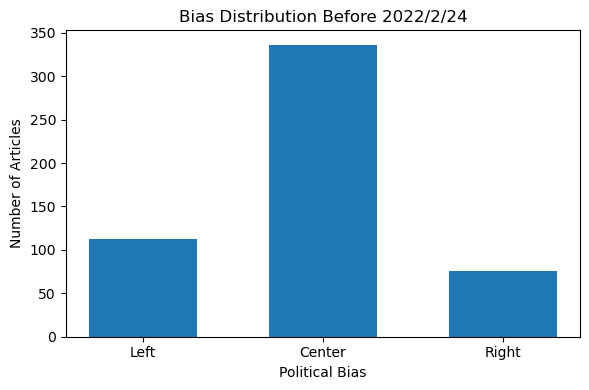

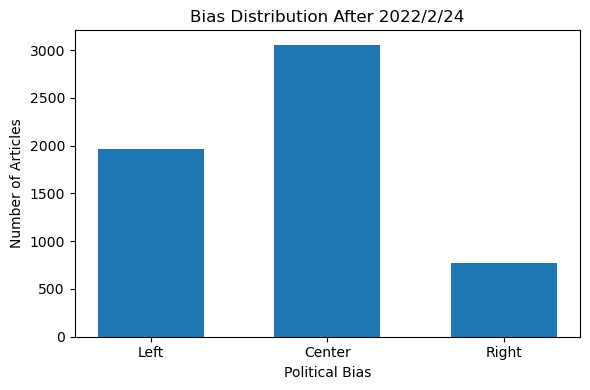

In [9]:

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
df = pd.read_csv("RU-BBC.csv")
# 👉 Step 1: 读取并转换日期列
df["published_date"] = pd.to_datetime(df["published_date"], format="%Y-%m-%d", errors="coerce")

# 👉 Step 2: 设置分界日期
cutoff_date = pd.to_datetime("2022/02/24")

# 👉 Step 3: 拆分数据集
df_before = df[df["published_date"] < cutoff_date]
df_after = df[df["published_date"] >= cutoff_date]

# ✅ 定义 bias 分类
bias_categories = ["Left", "Center", "Right"]
before_counts = df_before["bias"].value_counts().reindex(bias_categories, fill_value=0)
after_counts = df_after["bias"].value_counts().reindex(bias_categories, fill_value=0)

# ✅ 第一张图：Before 2022/2/26
plt.figure(figsize=(6, 4))
x = np.arange(len(bias_categories))
plt.bar(x, before_counts, width=0.6, color="#1f77b4")
plt.xticks(x, bias_categories)
plt.xlabel("Political Bias")
plt.ylabel("Number of Articles")
plt.title("Bias Distribution Before 2022/2/24")
plt.tight_layout()
plt.savefig("BBC_RU_before_2022_02_24.png")
plt.show()

# ✅ 第二张图：After 2022/2/26
plt.figure(figsize=(6, 4))
x = np.arange(len(bias_categories))
plt.bar(x, after_counts, width=0.6, color="#1f77b4")
plt.xticks(x, bias_categories)
plt.xlabel("Political Bias")
plt.ylabel("Number of Articles")
plt.title("Bias Distribution After 2022/2/24")
plt.tight_layout()
plt.savefig("BBC_RU_after_2022_02_24.png")
plt.show()



In [9]:
df = pd.read_csv("bbc_israel_2020_2024_advanced_filtered.csv")
df["bias"] = "" 
df

,title,published_date,authors,description,section,content,link,top_image,match_count,keyword_score,bias
0,Iran's Qasem Soleimani: Why the US had him in ...,2020-01-03,['https://www.facebook.com/bbcnews'],"Killed by the US, he was once described as the...",Middle East,Soleimani - seen here in Iraq in 2015 - direct...,http://www.bbc.co.uk/news/world-middle-east-50...,https://ichef.bbci.co.uk/news/976/cpsprodpb/64...,2,4.5,
1,Iran's Qasem Soleimani: Why the US had him in ...,2020-01-07,['https://www.facebook.com/bbcnews'],"Killed by the US, he was once described as the...",Middle East,Soleimani - seen here in Iraq in 2015 - direct...,http://www.bbc.co.uk/news/world-middle-east-50...,https://ichef.bbci.co.uk/news/976/cpsprodpb/64...,2,4.5,
2,Iran's Qasem Soleimani: Why the US had him in ...,2020-01-04,['https://www.facebook.com/bbcnews'],"Killed by the US, he was once described as the...",Middle East,Soleimani - seen here in Iraq in 2015 - direct...,http://www.bbc.co.uk/news/world-middle-east-50...,https://ichef.bbci.co.uk/news/976/cpsprodpb/64...,2,4.5,
3,Iran's Qasem Soleimani: Why the US had him in ...,2020-01-05,['https://www.facebook.com/bbcnews'],"Killed by the US, he was once described as the...",Middle East,Soleimani - seen here in Iraq in 2015 - direct...,http://www.bbc.co.uk/news/world-middle-east-50...,https://ichef.bbci.co.uk/news/976/cpsprodpb/64...,2,4.5,
4,Iran's Qasem Soleimani: Why the US had him in ...,2020-01-11,['https://www.facebook.com/bbcnews'],"Killed by the US, he was once described as the...",Middle East,Soleimani - seen here in Iraq in 2015 - direct...,http://www.bbc.co.uk/news/world-middle-east-50...,https://ichef.bbci.co.uk/news/976/cpsprodpb/64...,2,4.5,
...,...,...,...,...,...,...,...,...,...,...,...
3133,US will fear the vacuum that could replace Ass...,2024-12-08,https://www.facebook.com/bbcnews,Washington worries that the overthrow of Syria...,World,US will fear the vacuum that could replace Ass...,http://www.bbc.co.uk/news/articles/cj30enxzreyo,https://ichef.bbci.co.uk/ace/standard/1800/cps...,2,4.5,
3134,Israel seizes Golan buffer zone after Syrian t...,2024-12-08,https://www.facebook.com/bbcnews,PM Netanyahu said the 1974 disengagement agree...,Middle East,Israeli forces near Majdal Shams in the occupi...,http://www.bbc.co.uk/news/articles/c77jrrxxn07o,https://ichef.bbci.co.uk/ace/standard/3840/cps...,3,5.0,
3135,Israel carries out dozens of air strikes acros...,2024-12-09,https://www.facebook.com/bbcnews,Israel says it is acting to stop weapons falli...,Middle East,Israel carries out dozens of air strikes acros...,http://www.bbc.co.uk/news/articles/c4gxplxy550o,https://ichef.bbci.co.uk/ace/standard/1280/cps...,4,7.0,
3136,"Shaken by Assad's sudden fall, Syria faces sei...",2024-12-09,https://www.facebook.com/bbcnews,The worst scenario for Syrians is that their c...,Middle East,"Syrians may be celebrating the fall of Assad, ...",http://www.bbc.co.uk/news/articles/cp8n20z080ko,https://ichef.bbci.co.uk/ace/standard/3840/cps...,4,8.0,


In [6]:

def analyze_bias(i, content):
    prompt = build_prompt(content)  # 调用你的函数生成提示词
    
    try:
        response = client.chat.completions.create(
            model="deepseek-chat",
            messages=[{"role": "user", "content": prompt}],
            temperature=0.0,
            max_tokens=10,
            stop=["\n", ".", ","]
        )
        result = response.choices[0].message.content.strip()
    except Exception as e:
        result = f"[ERROR] {str(e)}"

    return i, result

# ✅ 使用线程池并发处理
with ThreadPoolExecutor(max_workers=5) as executor:
    futures = [executor.submit(analyze_bias, i, content) for i, content in enumerate(df["content"])]

    for future in as_completed(futures):
        i, result = future.result()
        df.at[i, "bias"] = result
        print(f"Processed {i+1}/{len(df)}: {result}")

# ✅ 保存处理结果
df.to_csv("BY2-BBC.csv", index=False)
print("✅ 已保存到 BY2-BBC.csv")


Processed 2/6314: Center
Processed 3/6314: Right
Processed 5/6314: Center
Processed 4/6314: Center
Processed 1/6314: Center
Processed 9/6314: Center
Processed 7/6314: Right
Processed 8/6314: Center
Processed 6/6314: Center
Processed 10/6314: Center
Processed 11/6314: Center
Processed 12/6314: Left
Processed 14/6314: Center
Processed 13/6314: Center
Processed 15/6314: Center
Processed 17/6314: Center
Processed 16/6314: Center
Processed 19/6314: Center
Processed 18/6314: Right
Processed 21/6314: Right
Processed 22/6314: Right
Processed 20/6314: Center
Processed 24/6314: Center
Processed 23/6314: Right
Processed 26/6314: Center
Processed 27/6314: Center
Processed 28/6314: Center
Processed 25/6314: Center
Processed 29/6314: Right
Processed 30/6314: Center
Processed 31/6314: Center
Processed 33/6314: Center
Processed 32/6314: Center
Processed 36/6314: Right
Processed 35/6314: Center
Processed 34/6314: Left
Processed 37/6314: Center
Processed 38/6314: Right
Processed 41/6314: Right
Processed

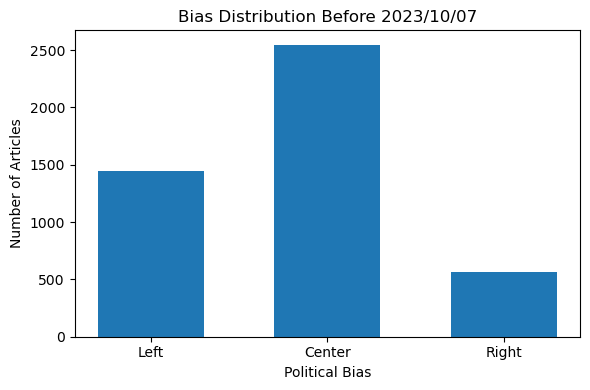

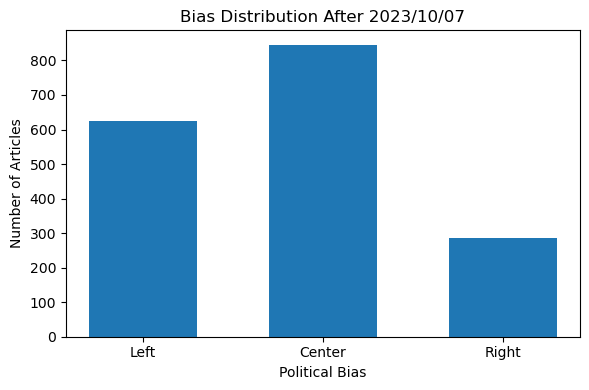

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
df = pd.read_csv("BY2-BBC.csv")
# 👉 Step 1: 读取并转换日期列
df["published_date"] = pd.to_datetime(df["published_date"], format="%Y-%m-%d", errors="coerce")

# 👉 Step 2: 设置分界日期
cutoff_date = pd.to_datetime("2023/10/07")

# 👉 Step 3: 拆分数据集
df_before = df[df["published_date"] < cutoff_date]
df_after = df[df["published_date"] >= cutoff_date]

# ✅ 定义 bias 分类
bias_categories = ["Left", "Center", "Right"]
before_counts = df_before["bias"].value_counts().reindex(bias_categories, fill_value=0)
after_counts = df_after["bias"].value_counts().reindex(bias_categories, fill_value=0)

# ✅ 第一张图：Before 2022/2/26
plt.figure(figsize=(6, 4))
x = np.arange(len(bias_categories))
plt.bar(x, before_counts, width=0.6, color="#1f77b4")
plt.xticks(x, bias_categories)
plt.xlabel("Political Bias")
plt.ylabel("Number of Articles")
plt.title("Bias Distribution Before 2023/10/07")
plt.tight_layout()
plt.savefig("BBC_BY_before_2023_10_07.png")
plt.show()

# ✅ 第二张图：After 2022/2/26
plt.figure(figsize=(6, 4))
x = np.arange(len(bias_categories))
plt.bar(x, after_counts, width=0.6, color="#1f77b4")
plt.xticks(x, bias_categories)
plt.xlabel("Political Bias")
plt.ylabel("Number of Articles")
plt.title("Bias Distribution After 2023/10/07")
plt.tight_layout()
plt.savefig("BBC_BY_after_2023_10_07.png")
plt.show()



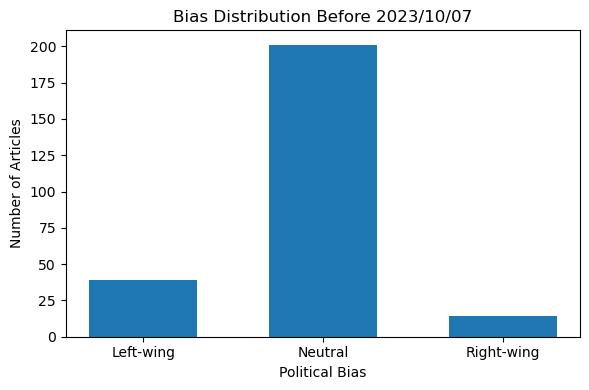

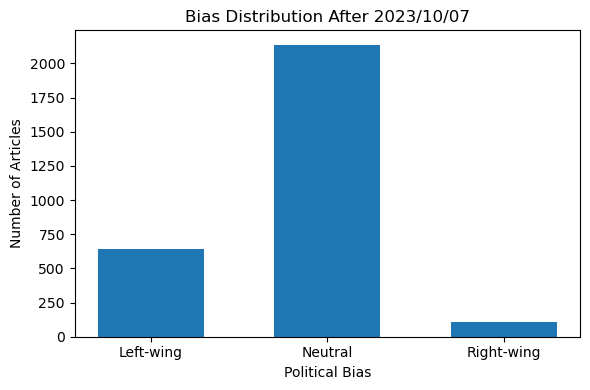

In [23]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("deepseek-BY-BBC.csv")
df["published_date"] = pd.to_datetime(df["published_date"], format="%Y-%m-%d", errors="coerce")

def compute_proportions(df):
    df["published_date"] = pd.to_datetime(df["published_date"], errors="coerce")
    df['year_month'] = df['published_date'].dt.to_period('M')
    monthly_total = df.groupby('year_month').size()
    monthly_bias = df.groupby(['year_month', 'bias']).size().unstack(fill_value=0)
    bias_categories = ["Left-wing", "Neutral", "Right-wing"]
    monthly_bias = monthly_bias.reindex(columns=bias_categories, fill_value=0)
    proportions = monthly_bias.div(monthly_total, axis=0)
    return proportions

prop_bbc = compute_proportions(df_bbc)


# To have common index
all_months = prop_bbc.index.union(prop_gua.index)
prop_bbc = prop_bbc.reindex(all_months, fill_value=0)


# Plot
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)
titles = ["LEFT Bias Proportion Over Time", "CENTER Bias Proportion Over Time", "RIGHT Bias Proportion Over Time"]
bias_map = {"Left-wing": 0, "Neutral": 1, "Right-wing": 2}

for bias, idx in bias_map.items():
    ax = axes[idx]
    ax.plot(prop_bbc.index.astype(str), prop_bbc[bias], color="#1f77b4", label="BBC")
    ax.plot(prop_gua.index.astype(str), prop_gua[bias], color="#ff7f0e", label="Guardian")
    ax.set_title(titles[idx])
    ax.set_xlabel("Month")
    ax.set_ylabel("Proportion")
    ax.legend()
    ax.tick_params(axis='x', rotation=45)

fig.suptitle("BBC vs. Guardian: Political Bias Trends Over Time (Israel-Hamas)")
plt.tight_layout()
plt.savefig("BBC_BY_bias_trends.png")  # 保存图片
plt.show()  # 可选：如果还想显示图片，可以保留

KeyError: 'published_date'

In [12]:
df = pd.read_csv("BY2-BBC.csv")
print(df["bias"].value_counts())
df = pd.read_csv("RU-BBC.csv")
print(df["bias"].value_counts())

bias
Center                                                                                                                                                      3390
Left                                                                                                                                                        2073
Right                                                                                                                                                        850
[ERROR] Error code: 400 - {'error': {'message': 'Content Exists Risk', 'type': 'invalid_request_error', 'param': None, 'code': 'invalid_request_error'}}       1
Name: count, dtype: int64
bias
Center                                                                                                                                                      3390
Left                                                                                                                                                        207